In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
from pyomo.dae import *

In [2]:
m = ConcreteModel()

m.R = Param(initialize=0.001) #  Friction factor
m.L = Param(initialize=100.0) #  Final position

m.tau = ContinuousSet(bounds=(0,1)) # Unscaled time
m.time = Var(m.tau) # Scaled time
m.tf = Var()
m.x = Var(m.tau,bounds=(0,m.L+50))
m.v = Var(m.tau,bounds=(0,None))
m.u = Var(m.tau, bounds=(-3.0,1.0),initialize=0)

m.dtime = DerivativeVar(m.time)
m.dx = DerivativeVar(m.x)
m.dv = DerivativeVar(m.v)

m.obj = Objective(expr=m.tf)

def _ode1(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = Constraint(m.tau, rule=_ode1)

def _ode2(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
m.ode2 = Constraint(m.tau, rule=_ode2)

def _ode3(m,i):
    if i == 0:
        return Constraint.Skip
    return m.dtime[i] == m.tf
m.ode3 = Constraint(m.tau, rule=_ode3)

def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    yield m.time[0] == 0
m.initcon = ConstraintList(rule=_init)

In [3]:
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m,nfe=15,scheme='BACKWARD')

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)
#discretizer.apply_to(m,nfe=15,scheme='LAGRANGE-LEGENDRE',ncp=3)

# force piecewise constant controls (acceleration) over each finite element
m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

solver = SolverFactory('ipopt')
solver.solve(m,tee=True)

print("final time = %6.2f" %(value(m.tf)))

Ipopt 3.5.4: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.5.4, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     7605
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     2104
                     variables with only lower bounds:      301
                variables with lower and upper bounds:      601
   

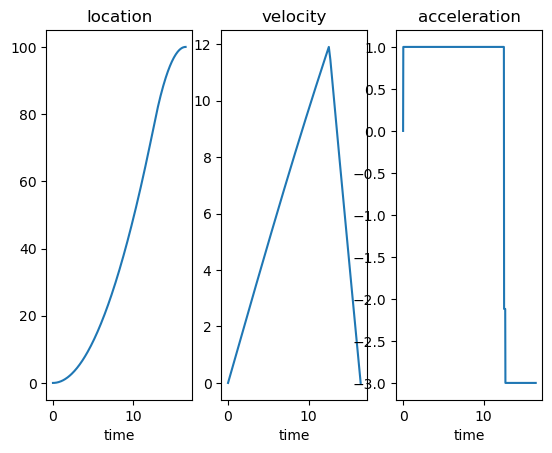

In [4]:
x = []
v = []
u = []
time=[]

for i in m.tau:
    time.append(value(m.time[i]))
    x.append(value(m.x[i]))
    v.append(value(m.v[i]))
    u.append(value(m.u[i]))
    
plt.subplot(131)
plt.plot(time,x,label='x')
plt.title('location')
plt.xlabel('time')

plt.subplot(132)
plt.plot(time,v,label='v')
plt.xlabel('time')
plt.title('velocity')

plt.subplot(133)
plt.plot(time,u,label='a')
plt.xlabel('time')
plt.title('acceleration')

plt.show()